In [1]:
from sklearn import datasets
iris = datasets.load_iris()

In [2]:
X=iris['data']
Y=iris['target']

In [3]:
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
def data_to_image(data):
    desire_col = 2
    desire_row = data.shape[1]/desire_col
    data_images = []
    font = ImageFont.truetype("./LiberationMono-Bold.ttf", size=35)
    for dat in data:
        background = np.zeros((255,255)).astype('uint8') #np.array([[0 for _ in range(255)] for _ in range(255)], dtype='uint8')
        image = Image.fromarray(background)
        draw = ImageDraw.Draw(image)
        for c, val in enumerate(dat):
            if len(str(val)) > 6: draw.text(((255//desire_col)*(c%desire_col), (255//desire_row)*(c//desire_col)), str(val)[:5], fill='white', font = font )
            else: draw.text(((255//desire_col)*(c%desire_col), (255//desire_row)*(c//desire_col)), str(val) , font = font, fill='white') 
        #rgb = np.array(image, dtype='uint8')
        rgb = [np.array(image, dtype='uint8') for _ in range(3)]
        data_images.append(rgb)
    return np.array(data_images) / 255 

X=data_to_image(X)

array([5.1, 3.5, 1.4, 0.2])

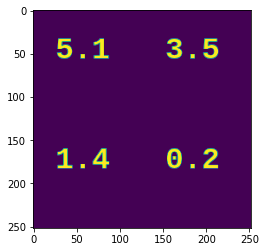

In [4]:
X=np.array([[np.pad(x[:200,:200],26) for x in k] for k in X])
plt.imshow(X[0,0,...]);# each number is value from features, we have 5 columns and 23 rows => 115 features as it should be
iris['data'][0,]

In [5]:
iris['data'].shape, X.shape

((150, 4), (150, 3, 252, 252))

### ResNet18

In [6]:
import torch.nn as nn
from torchvision import models


def resnet18update(net, only_last = True):
   if only_last:
      for name, param in net.named_parameters():
        if 'fc' not in name and 'act' not in name: param.requires_grad = False  # freezing all except classifier
      for name, param in net.layer4[1].named_parameters():
        param.requires_grad = True   # unfreezing last sub-block
   else:
      for name, param in net.named_parameters():
          if 'layer4' not in name:
              param.requires_grad = False
          else:
              break
   for name, param in net.named_parameters():
        if param.requires_grad: print(name)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import numpy as np
import torchvision
from torchvision import *

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

## Train Validation

In [8]:
from sklearn.model_selection import train_test_split as tts
x_train,x_test,y_train,y_test=tts(X,Y, test_size=0.2,random_state=8)

device=torch.device('cpu')
train_data = torch.utils.data.DataLoader(list(zip(x_train,y_train)), batch_size=8, shuffle=True, drop_last=True,num_workers=2)
validation_data = torch.utils.data.DataLoader(list(zip(x_test,y_test)),batch_size=1000,num_workers=2)

In [9]:
def accuracy(pred,y):
    return sum(pred==y)/len(y)
from sklearn.metrics import precision_recall_curve, f1_score, auc, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean
from sklearn.model_selection import KFold, train_test_split
torch.manual_seed(0)
Train_stats=[]
Test_stats=[]
device='cuda:0'

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10, shuffle=True)
if(True):
 train_data = torch.utils.data.DataLoader(list(zip(X_train,Y_train)), batch_size=32, shuffle=True, drop_last=True,num_workers=2)
 validation_data = torch.utils.data.DataLoader(list(zip(X_test,Y_test)),batch_size=1,num_workers=2) 

 net = models.resnet18(pretrained=True)
 num_features = net.fc.in_features
 net.fc= nn.Linear(num_features, 3)            
 resnet18update(net)
 net = nn.Sequential(net, nn.Softmax(1)) 
 net=net.to(device)
 #loss and optim
 criterion = nn.CrossEntropyLoss()
 optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
 
 for epoch in range(15):
   
    
    Names=['Epoch','Accuracy','Loss']
    
    Stats={}
    
    Stats['Accuracy']=0
    
    if(True):
     Stats=[]
     for i, (inputs, labels) in enumerate(train_data):
        net.train()
        inputs = inputs.to(device, dtype=torch.float); 
        optimizer.zero_grad()
        outputs = net(inputs)
        labels=labels.to(device).long()
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        average='micro'
        _,pred = torch.max(outputs, dim=1)
        Stats.append([epoch+1,accuracy(pred,labels).item(),loss.item()])
     Stats={key:val for key,val in zip(Names,np.mean(np.asarray(Stats).T,axis=1))}
    
    Train_stats.append(Stats)
    print("-----      TRAIN RESULTS      -----")
    print(Train_stats[-1])
 
    Stats=[]

    for i, (inputs, labels) in enumerate(validation_data):
        net.eval()
        inputs = inputs.to(device, dtype=torch.float); 
        outputs = net(inputs)
        labels=labels.to(device).long()
        loss = criterion(outputs,labels)

        _,pred = torch.max(outputs, dim=1)
        Stats.append([epoch+1,accuracy(pred,labels).item(),loss.item()])
    
    Test_stats.append({key:val for key,val in zip(Names,np.mean(np.asarray(Stats).T,axis=1))})
    print("-----      TEST  RESULTS     -----")
    print(Test_stats[-1])
 

layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias
-----      TRAIN RESULTS      -----
{'Epoch': 1.0, 'Accuracy': 0.4270833333333333, 'Loss': 1.0621439615885417}
-----      TEST  RESULTS     -----
{'Epoch': 1.0, 'Accuracy': 0.23333333333333334, 'Loss': 1.1148563504219056}
-----      TRAIN RESULTS      -----
{'Epoch': 2.0, 'Accuracy': 0.6041666666666666, 'Loss': 1.0103634595870972}
-----      TEST  RESULTS     -----
{'Epoch': 2.0, 'Accuracy': 0.5, 'Loss': 1.082342952489853}
-----      TRAIN RESULTS      -----
{'Epoch': 3.0, 'Accuracy': 0.8333333333333334, 'Loss': 0.8781612118085226}
-----      TEST  RESULTS     -----
{'Epoch': 3.0, 'Accuracy': 0.6666666666666666, 'Loss': 1.0564051389694213}
-----      TRAIN RESULTS      -----
{'Epoch': 4.0, 'Accuracy': 0.9375, 'Loss': 0.7816721598307291}
-----      TEST  RESULTS     -----
{'Epoch': 4.0, 'Accuracy': 0.6, 'Loss': 1.037967417637507}
-----      TRAIN RESU

In [10]:
Test=pd.DataFrame(Test_stats)
Train=pd.DataFrame(Train_stats)

In [12]:
Test.to_csv('Iris.csv')

In [13]:
Test

,Epoch,Accuracy,Loss
0,1.0,0.233333,1.114856
1,2.0,0.500000,1.082343
2,3.0,0.666667,1.056405
3,4.0,0.600000,1.037967
4,5.0,0.766667,1.027033
5,6.0,0.833333,1.002989
6,7.0,0.633333,0.987146
7,8.0,0.633333,0.984240
8,9.0,0.533333,0.980239
9,10.0,0.566667,0.949822
